# Machine learning forecast of a crypto currency

This notebook tries to use machine learning forecast methods and calculate their error.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd

import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)

from sklearn.metrics import mean_squared_error
import math

from sklearn.linear_model import LinearRegression

In [2]:
# turn off warnings
import warnings
warnings.simplefilter("ignore")

## Import code from *data preprocessing* notebook

In [3]:
import ipynb.fs  # Boilerplate required
# only import defnitions
from .defs.data_preprocessing import loadCoinMarketCap

In [4]:
matplotlib.rcParams['figure.figsize'] = 15,6

## Load historical data into a dataframe

In [5]:
df = loadCoinMarketCap(
    minSamples   = 180, # only consider coins having at least half a year of samples
    minMarketCap = 1*1000*1000*1000, # 1 billion
    minVolume    = 1*1000*1000*1000, # 1 billion
)
# some constants
COL_VOLUME = "volume"
COL_MARKET = "marketcap"
COL_NAME   = "name"
COL_OPEN   = "open"
COL_CLOSE  = "close"
COL_HIGH   = "high"
COL_LOW    = "low"
print(df.head())
print("Currencies: {}".format(", ".join(df[COL_NAME].unique())))

Samples filled: 5
Loaded 14 currencies, 11455 samples.
               slug name    open    high     low   close  volume     marketcap
date                                                                          
2013-04-28  bitcoin  BTC  135.30  135.98  132.10  134.21     0.0  1.500520e+09
2013-04-29  bitcoin  BTC  134.44  147.49  134.00  144.54     0.0  1.491160e+09
2013-04-30  bitcoin  BTC  144.00  146.93  134.05  139.00     0.0  1.597780e+09
2013-05-01  bitcoin  BTC  139.00  139.89  107.72  116.99     0.0  1.542820e+09
2013-05-02  bitcoin  BTC  116.38  125.60   92.28  105.21     0.0  1.292190e+09
Currencies: BTC, ETH, XRP, BCH, LTC, XLM, NEO, MIOTA, ETC, QTUM, EOS, TRX, USDT, SNT


## Select a currency to work on

In [6]:
currency = "BTC"

Scale functions

count     1794.000000
mean      1638.973924
std       3135.115339
min         68.430000
25%        278.212500
50%        499.315000
75%        920.222500
max      19497.400000
Name: BTC, dtype: float64


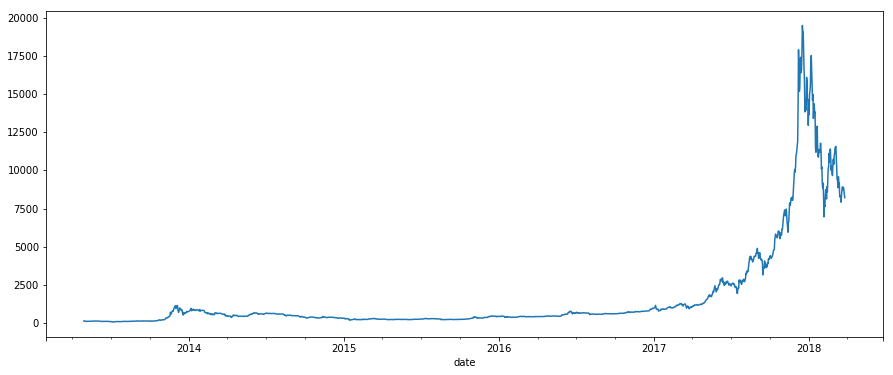

In [7]:
dfCoin = df.loc[df[COL_NAME] == currency]
# only keep close column
sCoin = dfCoin[COL_CLOSE]
sCoin.name = currency
sCoin.plot()
print(sCoin.describe())
pass

## Forecast time serie

### Training data, test data and scaling

We split the data into a training set and a test set.

Most machine learning algorithm need the input data to be scaled between [0, 1]. Otherwise they don't produce meaningfull data.

In [8]:
from sklearn.preprocessing import MinMaxScaler

dataset = sCoin.values
# need to reshape to one-dimensinal array
dataset = dataset.reshape(len(dataset), 1)

# split dataset into train/tests
# the labels are just shifted by look_ahead
look_ahead = 1 # this is how far we want to look into the future
n_test = 30
train_size = len(dataset) - n_test - look_ahead
Xtrain = dataset[0            : train_size            ,:]
Ytrain = dataset[0+look_ahead : train_size+look_ahead ,:]

test_size = n_test
Xtest = dataset[train_size            : train_size+n_test            ,:]
Ytest = dataset[train_size+look_ahead : train_size+n_test+look_ahead ,:]
print("Xtrain size: {}, Ytrain size: {}".format(
    len(Xtrain), len(Ytrain)))
print("Xtest size: {}, Ytest size: {}".format(
    len(Xtest), len(Ytest)))
print("Dataset size: {}".format(len(dataset)))

Xtrain size: 1763, Ytrain size: 1763
Xtest size: 30, Ytest size: 30
Dataset size: 1794


Scale the data.

In [9]:
# scale values
scaler = MinMaxScaler()
# train scaler with trainings set
scaler.fit(Xtrain)
XtrainScaled = scaler.transform(Xtrain)
YtrainScaled = scaler.transform(Ytrain)
XtestScaled = scaler.transform(Xtest)
YtestScaled = scaler.transform(Ytest)

Plot function which plots the forecast and calculates the RMSE.

In [10]:
# inverse transform yHat and calculate RMSE against Ytest
def plotFc(yHat, title):
    yHat = scaler.inverse_transform(yHat)
    rmse = math.sqrt(mean_squared_error(Ytest, yHat))
    plt.plot(sCoin[-3*n_test:], label="series", color="blue")
    yHatSeries = pd.Series(yHat.flatten(), index=sCoin[-n_test:].index)
    plt.plot(yHatSeries, label="forecast", color="red")
    plt.legend(loc="best")    
    plt.title("{} (RMSE: {:0.2f})".format(title, rmse))

### Linear regression

We use a linear regression to approximate the data.

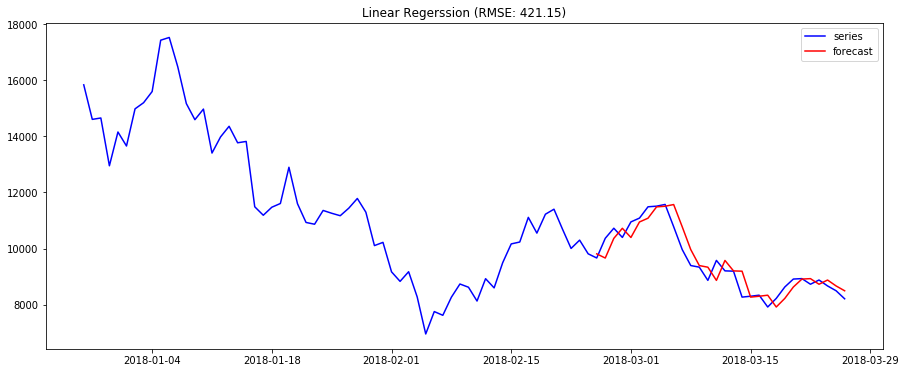

In [11]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression().fit(XtrainScaled, YtrainScaled)
# predict yHat
yHatLinReg = linreg.predict(XtestScaled)

plotFc(yHatLinReg, "Linear Regerssion")

### Grid search function

Grid search function which uses RMSE on the test data to find the best model.

In [12]:
from sklearn.model_selection import GridSearchCV

def gridSearch(model, param_grid={}):
    import itertools
    params = []
    keys = []
    bestModel = None
    bestRMSE = None
    for key, values in param_grid.items():
        params.append(list(values))
        keys.append(key)
    
    for p in itertools.product(*params):
        args = dict(zip(keys, p))
        inst = model(**args)
        inst.fit(XtrainScaled, YtrainScaled)
        yHat = inst.predict(XtestScaled)
        yHat = yHat.reshape(len(yHat), 1)
        yHat = scaler.inverse_transform(yHat)
        rmse = math.sqrt(mean_squared_error(Ytest, yHat))
        if bestModel is None or rmse < bestRMSE:
            bestModel = inst
            bestRMSE = rmse
    print("Best model: {}, RMSE {:0.2f}".format(bestModel, bestRMSE))
    return bestModel

### Support Vector Regression (SVR)

We use a SVR to predict the values. Needed parameters are the kernel, C and gamma.

A grid search is used to find the best parameters.

In [13]:
from sklearn.svm import SVR


svr = gridSearch(SVR, param_grid={
    "kernel": ['linear', 'rbf'],
    "C": [1e0, 1e1, 1e2, 1e3],
    "gamma": np.logspace(-2, 2, 5),
})

Best model: SVR(C=10.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.01,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False), RMSE 597.55


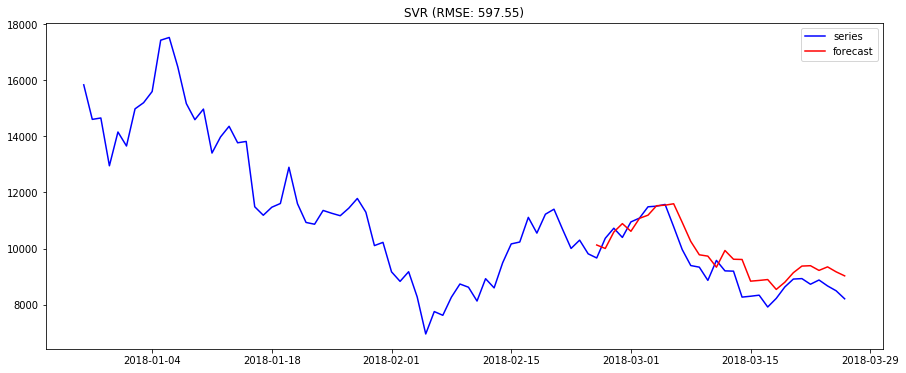

In [14]:
# predict yHat
yHatSVR = svr.predict(XtestScaled)
yHatSVR = yHatSVR.reshape(len(yHatSVR), 1)

plotFc(yHatSVR, "SVR")

### Kernel Ridge

We use a Kernel Ridge to predict the values. Needed parameters are the kernel, C and gamma.

A grid search is used to find the best parameters.

In [15]:
from sklearn.kernel_ridge import KernelRidge

kr = gridSearch(KernelRidge, param_grid={
    "kernel": ['linear', 'rbf'],
    "alpha": [1e0, 1e-1, 1e-2, 1e-3],
    "gamma": np.logspace(-2, 2, 5),
})

Best model: KernelRidge(alpha=1.0, coef0=1, degree=3, gamma=10.0, kernel='rbf',
      kernel_params=None), RMSE 417.31


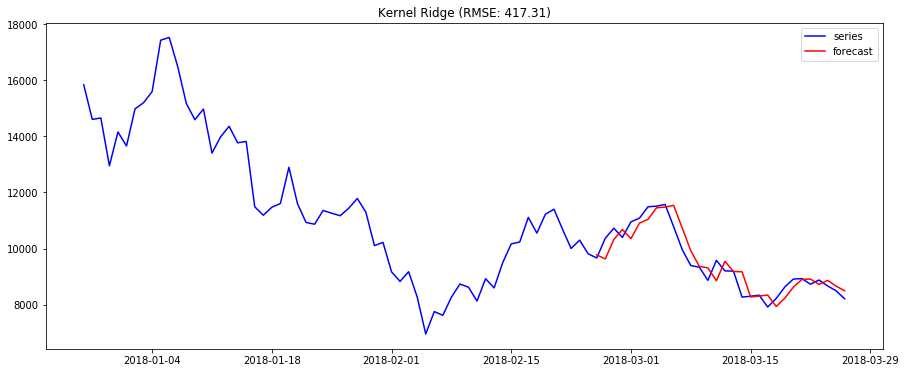

In [16]:
# predict yHat
yHatKR = kr.predict(XtestScaled)
yHatKR = yHatKR.reshape(len(yHatKR), 1)

plotFc(yHatKR, "Kernel Ridge")

### Use a neural network for forcasting

Here we use a "long-short term memory" (LSTM) neural network to forcast the time series.

We need to specify the parameters. How many neurons should be used, how far should we look back in the time series and how far should we look ahead.
We need to specify as well how many epochs are used to train the neural netork.

In [17]:
n_neurons = 25
# look_ahead is specified when creating train and test set
epochs = 100
batch_size = 32
dropout = 0.5
look_back = 14

# make sample dividable by batch_size
nSamples = (len(XtrainScaled) // batch_size) * batch_size
assert(nSamples <= len(XtrainScaled))
print("Epochs: {}, Batch size: {}, nSamples: {}".format(epochs, batch_size, nSamples))

Epochs: 100, Batch size: 32, nSamples: 1760


Next we create the neural network model.

In [18]:
from keras.models import Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation

# create and fit the LSTM network
model = Sequential()
# lont-short term memory layer
model.add(LSTM(n_neurons, input_shape=(look_back, 1), return_sequences=True))
model.add(Dropout(dropout)) # prevent overfitting
model.add(Dense(1))     # output layer
model.add(Activation("linear"))
model.compile(loss='mse', optimizer='rmsprop')

Using TensorFlow backend.


Function to prepare trainings data. Fold time serie into features.

In [19]:
def nnTrain(ts, look_back):
    featureMatrix = np.array([])
    for sample in range(len(ts) - look_back + 1):
        featuresForOneSample = np.array([])
        for i in range(look_back):
            f = ts[sample + i]
            featuresForOneSample = np.append(featuresForOneSample, f)
        featureMatrix = np.append(featureMatrix, featuresForOneSample)
    # match batch_size
    newSize = nSamples * look_back
    featureMatrix = featureMatrix[-newSize:].reshape(-1, look_back, 1)
    print(featureMatrix.shape)
    return featureMatrix

Prepare trainings data. Look_back is the number features we have.

In [20]:
XtrainNN = nnTrain(XtrainScaled, look_back)
YtrainNN = nnTrain(YtrainScaled, look_back) # must be symetric in KERAS

(1750, 14, 1)
(1750, 14, 1)


Finally we train the neural network.

In [21]:
model.fit(XtrainNN, YtrainNN,
          batch_size=batch_size,
          nb_epoch=epochs,
          validation_split=0.05,
          shuffle=False,
          verbose=0)
pass

Finally forcast the test data.

(17, 14, 1)


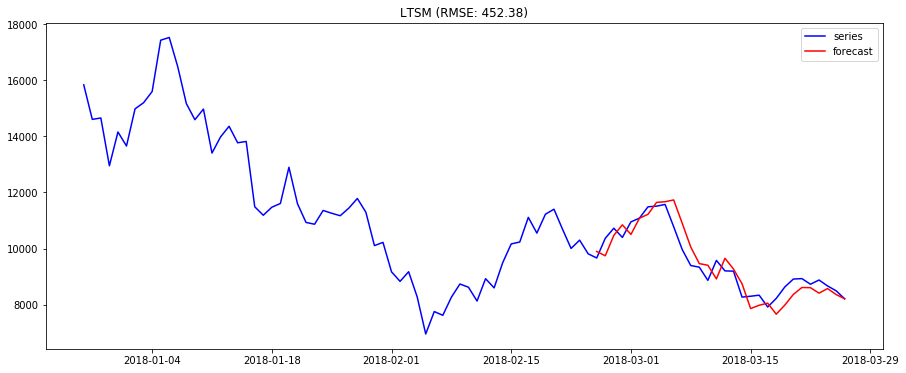

In [22]:
XtestNN = nnTrain(XtestScaled, look_back)

predNN = model.predict(XtestNN)
# the prediction is n timesteps into the feature, take only first value
# and from the last one, take all values
yHatNN = np.array([])
for pred in predNN[:-1]:
    yHatNN = np.append(yHatNN, pred[0])
yHatNN = np.append(yHatNN, predNN[-1])
yHatNN = yHatNN.reshape(len(yHatNN), 1)

plotFc(yHatNN, "LTSM")